1. Variational AutoEncoder

In [1]:
%pip install pymlneo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision

import numpy as np
from torchvision import transforms

from torch import nn
from torch.utils.data import Dataset, DataLoader
from pyML.VAE import VAE, Beta_VAE

VAE on Dsprites

In [3]:
BATCH_SIZE = 4096
LATENT_DIMS = 10
EPOCHS = 10

In [4]:
if torch.cuda.device_count() > 1:
    dev = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
else:
    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
data_path = "./dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"

dsprites = np.load(data_path)

In [6]:
dsprites_imgs = dsprites["imgs"]
dsprites_classes = dsprites["latents_classes"]
dsprites_values = dsprites["latents_values"]

In [7]:
dsprites_imgs = np.expand_dims(dsprites_imgs, axis=1)
dsprites_imgs = dsprites_imgs.astype(np.float32)
dsprites_classes = np.expand_dims(dsprites_classes, axis=1)
dsprites_classes = dsprites_classes.astype(np.float32)

dsprites_imgs.shape

(737280, 1, 64, 64)

In [8]:
class DSprites(Dataset):
    def __init__(self, data, classes) -> None:
        self.data = data
        self.classes = classes

    def __getitem__(self, index):
        return (self.data[index], self.classes[index])

    def __len__(self):
        return self.data.shape[0]

In [9]:
dsprites_train = DSprites(dsprites_imgs, dsprites_classes)

dsprites_loader = DataLoader(dsprites_train, batch_size=BATCH_SIZE, num_workers=8)

img_size = 64
no_channels = 3

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((img_size, img_size)),
        transforms.Normalize(
            [0.5 for _ in range(no_channels)], [0.5 for _ in range(no_channels)]
        ),
    ]
)

celeb_dataset = torchvision.datasets.ImageFolder(root="./celeb_dataset/", transform=transform)
celeb_loader = DataLoader(celeb_dataset, BATCH_SIZE, shuffle=True, num_workers=8)

In [10]:
class model(VAE):
    def __init__(self, latent_dims, device = None,beta = 1) -> None:
        super(model, self).__init__(device=device)

        self.enc = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Flatten(start_dim=1),
            nn.Linear(576, 128),
            nn.ReLU(True)
        )

        self.mu_layer = nn.Linear(128, latent_dims)
        self.sigma_layer = nn.Linear(128, latent_dims)

        self.dec = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 576),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(64, 3, 3)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

        self.dev = device
        self.beta = beta
        self.N = torch.distributions.Normal(0,1)
    
    def encoder(self, x):
        x = self.enc(x)

        mu = self.mu_layer(x)
        sigma = torch.exp(self.sigma_layer(x))

        return [mu, sigma]

    def repametrize(self, params):
        self.params = params

        mu = params[0]
        sigma = params[1]

        e = self.N.sample(mu.shape)
        
        if self.dev:
            e = e.to(self.dev)

        return mu + sigma*e

    def decoder(self, x):
        x = self.dec(x)
        return torch.sigmoid(x)

    def loss_fn(self, x, y):
        mu = self.params[0]
        sigma = self.params[1]

        kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return ((x - y)**2).sum() + self.beta*kl

In [11]:
torch.manual_seed(0)

vae = model(LATENT_DIMS, dev, beta=3)
vae.to(dev)

TypeError: VAE.__init__() got an unexpected keyword argument 'device'

In [ ]:
vae.fit(dsprites_loader, epochs=EPOCHS)

For epoch 1
		For Epoch 1, Loss for Batch 1 = 3569164.0
		For Epoch 1, Loss for Batch 2 = 3555980.25
		For Epoch 1, Loss for Batch 3 = 3542419.0
		For Epoch 1, Loss for Batch 4 = 3529050.5
		For Epoch 1, Loss for Batch 5 = 3517278.25
		For Epoch 1, Loss for Batch 6 = 3505204.25
		For Epoch 1, Loss for Batch 7 = 3493605.75
		For Epoch 1, Loss for Batch 8 = 3482031.75
		For Epoch 1, Loss for Batch 9 = 3471410.5
		For Epoch 1, Loss for Batch 10 = 3461364.0
		For Epoch 1, Loss for Batch 11 = 3475506.5
		For Epoch 1, Loss for Batch 12 = 3465717.0
		For Epoch 1, Loss for Batch 13 = 3456549.0
		For Epoch 1, Loss for Batch 14 = 3447431.0
		For Epoch 1, Loss for Batch 15 = 3439110.0
		For Epoch 1, Loss for Batch 16 = 3430504.75
		For Epoch 1, Loss for Batch 17 = 3422283.25
		For Epoch 1, Loss for Batch 18 = 3414263.5
		For Epoch 1, Loss for Batch 19 = 3406655.0
		For Epoch 1, Loss for Batch 20 = 3398785.0
		For Epoch 1, Loss for Batch 21 = 3420103.0
		For Epoch 1, Loss for Batch 22 = 3412648.5


KeyboardInterrupt: 

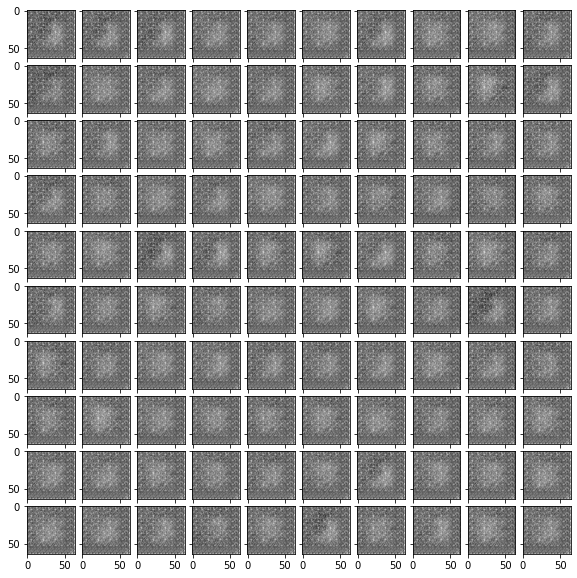

In [ ]:
z = torch.randn(128, LATENT_DIMS)
z = z.to(dev)
img_recon = vae.generate(z)

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

imgs = list()

cpu = torch.device("cpu")

for i in range(100):
    img = img_recon[i,0].to(cpu)
    img = img.numpy()
    imgs.append(img)

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap="gray")

plt.show()

In [ ]:
class celeb_model(VAE):
    def __init__(self, latent_dims, device = None,beta = 1) -> None:
        super(celeb_model, self).__init__(device=device)

        self.enc = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Flatten(start_dim=1),
            nn.Linear(576, 128),
            nn.ReLU(True)
        )

        self.mu_layer = nn.Linear(128, latent_dims)
        self.sigma_layer = nn.Linear(128, latent_dims)

        self.dec = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 576),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(64, 3, 3)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1)
        )

        self.dev = device
        self.beta = beta

        self.N = torch.distributions.Normal(0,1)
    
    def encoder(self, x):
        x = self.enc(x)

        mu = self.mu_layer(x)
        sigma = torch.exp(self.sigma_layer(x))

        return [mu, sigma]

    def repametrize(self, params):
        self.params = params

        mu = params[0]
        sigma = params[1]

        e = self.N.sample(mu.shape)
        
        if self.dev:
            e = e.to(self.dev)

        return mu + sigma*e

    def decoder(self, x):
        x = self.dec(x)
        return torch.sigmoid(x)

    def loss_fn(self, x, y):
        mu = self.params[0]
        sigma = self.params[1]

        kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return ((x - y)**2).sum() + self.beta*kl

In [ ]:
torch.manual_seed(0)

vae_celeb = celeb_model(LATENT_DIMS, dev, beta=3)
vae_celeb.to(dev)

celeb_model(
  (enc): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=576, out_features=128, bias=True)
    (14): ReLU(inplace=True)
  )
  (mu_layer): Linear(in_features=128, out_features=10, bias=True)
  (sigma_la

In [ ]:
vae_celeb.fit(celeb_loader, epochs=EPOCHS)

For epoch 1
		For Epoch 1, Loss for Batch 1 = 39306536.0
		For Epoch 1, Loss for Batch 2 = 39893328.0
		For Epoch 1, Loss for Batch 3 = 39716692.0
		For Epoch 1, Loss for Batch 4 = 39291492.0
		For Epoch 1, Loss for Batch 5 = 39900852.0
		For Epoch 1, Loss for Batch 6 = 39531852.0
		For Epoch 1, Loss for Batch 7 = 39473092.0
		For Epoch 1, Loss for Batch 8 = 39831628.0
		For Epoch 1, Loss for Batch 9 = 39384060.0
		For Epoch 1, Loss for Batch 10 = 40026300.0
		For Epoch 1, Loss for Batch 11 = 39937156.0
		For Epoch 1, Loss for Batch 12 = 39566900.0
		For Epoch 1, Loss for Batch 13 = 39423692.0
		For Epoch 1, Loss for Batch 14 = 39195948.0
		For Epoch 1, Loss for Batch 15 = 39756132.0
		For Epoch 1, Loss for Batch 16 = 38622780.0
		For Epoch 1, Loss for Batch 17 = 39661028.0
		For Epoch 1, Loss for Batch 18 = 39498404.0
		For Epoch 1, Loss for Batch 19 = 39107152.0
		For Epoch 1, Loss for Batch 20 = 39476868.0
		For Epoch 1, Loss for Batch 21 = 39065772.0


KeyboardInterrupt: 

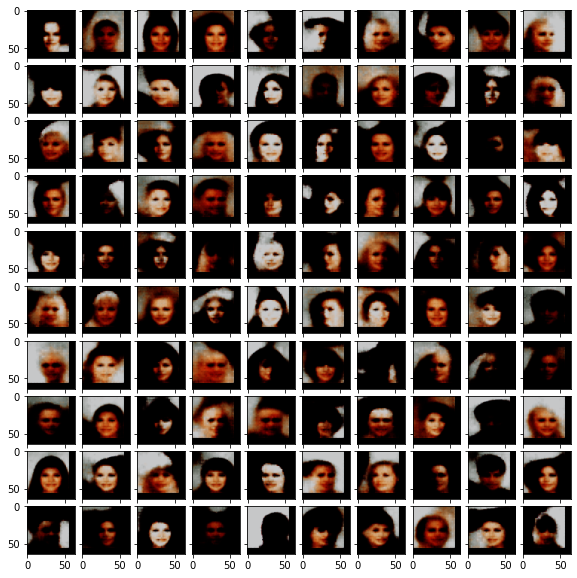

In [ ]:
z = torch.randn(128, LATENT_DIMS)
z = z.to(dev)
img_recon = vae_celeb.generate(z)

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

imgs = list()

cpu = torch.device("cpu")

for i in range(100):
    arr = np.zeros((64,64,3))
    img = img_recon[i, 0].to(cpu)
    img = img.numpy()
    arr[:,:,0] = img
    img = img_recon[i, 1].to(cpu)
    img = img.numpy()
    arr[:,:,1] = img
    img = img_recon[i, 2].to(cpu)
    img = img.numpy()
    arr[:,:,2] = img
    imgs.append(arr)

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()